In [1]:
!pip install fiftyone
!pip install transformers
!pip install super-gradients

You should consider upgrading via the 'C:\Users\anssi\Desktop\ai\env\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\anssi\Desktop\ai\env\Scripts\python.exe -m pip install --upgrade pip' command.


  Using cached super_gradients-3.5.0-py3-none-any.whl (12.0 MB)
  Using cached data_gradients-0.3.1-py3-none-any.whl (459 kB)
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached onnxruntime-1.13.1-cp310-cp310-win_amd64.whl (5.9 MB)
  Using cached sphinx_rtd_theme-2.0.0-py2.py3-none-any.whl (2.8 MB)
  Using cached pip_tools-7.3.0-py3-none-any.whl (57 kB)
  Using cached onnx-1.13.0-cp310-cp310-win_amd64.whl (12.2 MB)
  Using cached protobuf-3.20.3-cp310-cp310-win_amd64.whl (904 kB)
  Using cached treelib-1.6.1-py3-none-any.whl
  Using cached opencv_python-4.8.1.78-cp37-abi3-win_amd64.whl (38.1 MB)
  Using cached json_tricks-3.16.1-py2.py3-none-any.whl (27 kB)
  Using cached Sphinx-4.0.3-py3-none-any.whl (2.9 MB)
  Using cached omegaconf-2.3.0-py3-none-any.whl (79 kB)
  Using cached stringcase-1.2.0-py3-none-any.whl
  Using cached coverage-5.3.1-py3-none-any.whl
  Using cached onnx_simplifier-0.4.35-cp310-cp310-win_amd64.whl (1.2 MB)
  Using cached hydra_core-1.3.2-py3-none-any

  error: subprocess-exited-with-error
  
  exit code: 1
  
  [17 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-310
  creating build\lib.win-amd64-cpython-310\pycocotools
  copying pycocotools\coco.py -> build\lib.win-amd64-cpython-310\pycocotools
  copying pycocotools\cocoeval.py -> build\lib.win-amd64-cpython-310\pycocotools
  copying pycocotools\mask.py -> build\lib.win-amd64-cpython-310\pycocotools
  copying pycocotools\__init__.py -> build\lib.win-amd64-cpython-310\pycocotools
  running build_ext
  C:\Users\anssi\AppData\Local\Temp\pip-build-env-e20r7o40\overlay\Lib\site-packages\Cython\Compiler\Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: C:\Users\anssi\AppData\Local\Temp\pip-install-d06ddqv2\pycocotools_307e27bd08ee4fb2ab65130e7bf8982e\pycocotools\_mask.pyx
    tree = Parsing.p_module(s, pxd, full_m

In [2]:
!pip install torch torchvision

You should consider upgrading via the 'C:\Users\anssi\Desktop\ai\env\Scripts\python.exe -m pip install --upgrade pip' command.


In [3]:
import torch
import torchvision
from transformers import DetrForObjectDetection, DetrImageProcessor
# Run the model on GPU if it is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load a pre-trained Faster R-CNN model
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model.to(device)
model.eval()

print("Model ready")

C:\Users\anssi\Desktop\ai\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Model ready


In [4]:
import fiftyone as fo
import fiftyone.zoo as foz

#dataset = foz.load_zoo_dataset(
 #   "coco-2017",
  #  split="validation",
   # dataset_name="evaluate-detections-tutorial",
#)
name="coco-to-resized_testing-5"
dataset_dir="./coco_resized/validation"
dataset_type = fo.types.COCODetectionDataset
dataset = fo.Dataset.from_dir(dataset_dir, dataset_type, name=name)
dataset.persistent = False
predictions_view = dataset.take(20, seed=51)

 100% |███████████████| 5000/5000 [19.0s elapsed, 0s remaining, 252.8 samples/s]      


In [5]:
# Print some information about the dataset
print(dataset)

Name:        coco-to-resized_testing-5
Media type:  image
Num samples: 5000
Persistent:  False
Tags:        []
Sample fields:
    id:         fiftyone.core.fields.ObjectIdField
    filepath:   fiftyone.core.fields.StringField
    tags:       fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    detections: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


In [6]:
# Print a ground truth detection
sample = dataset.first()
#print(sample.detections)


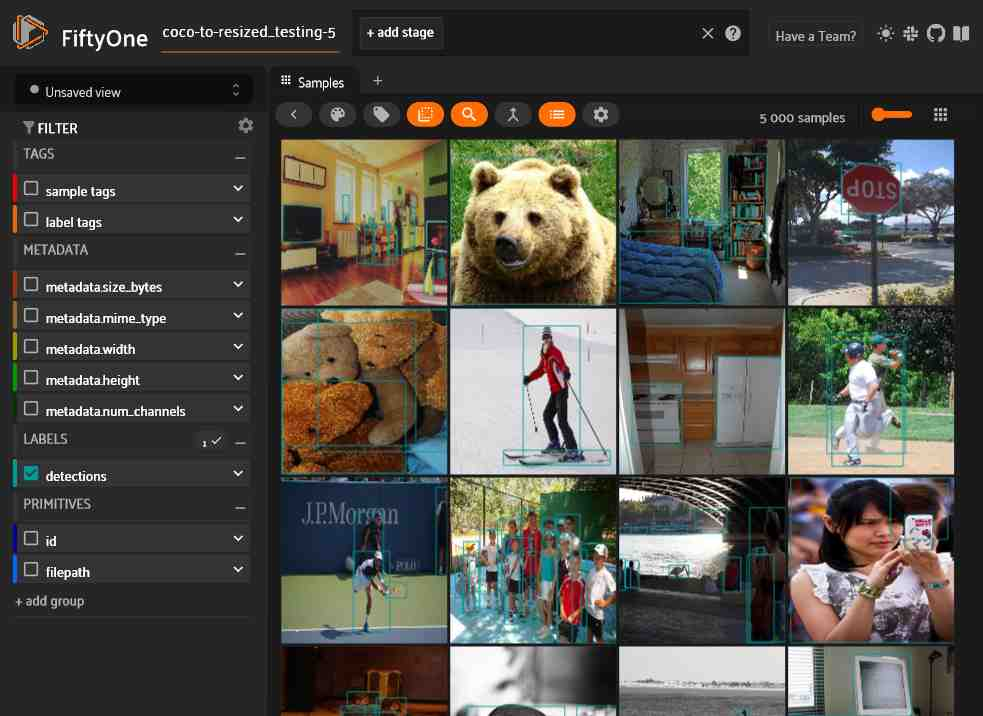

In [7]:
session = fo.launch_app(dataset)

In [8]:
# Choose a random subset of 100 samples to add predictions to
#predictions_view = dataset.take(100, seed=51)

In [9]:
from PIL import Image
from torchvision.transforms import functional as func

import fiftyone as fo

# Get class list
classes = dataset.default_classes

# Add predictions to samples
for sample in predictions_view:
    image = Image.open(sample.filepath)

    # you can specify the revision tag if you don't want the timm dependency
    image_as_tensor = func.to_tensor(image).to(device)

    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)

    c, h, w = image_as_tensor.shape

    # convert outputs (bounding boxes and class logits) to COCO API
    # let's only keep detections with score > 0.9
    target_sizes = torch.tensor([image.size[::-1]])
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]
    detections = []
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        #print(
         #       f"Detected {model.config.id2label[label.item()]} with confidence "
          #      f"{round(score.item(), 3)} at location {box}"
        #)
        x1, y1, x2, y2 = box
        rel_box = [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]
        
    #for label, score, box in zip(labels, scores, boxes):
        # Convert to [top-left-x, top-left-y, width, height]
        # in relative coordinates in [0, 1] x [0, 1]
     #   x1, y1, x2, y2 = box
      #  rel_box = [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]

        detections.append(
            fo.Detection(
                label=model.config.id2label[label.item()],
                bounding_box=rel_box,
                confidence=score.item()
            )
        )

    # Save predictions to dataset
    sample["detr"] = fo.Detections(detections=detections)
    sample.save()
print(detections)
print(box)
print(score.item())
print("Finished adding predictions")

[<Detection: {
    'id': '65686e5a80d898755590e4b3',
    'attributes': {},
    'tags': [],
    'label': 'parking meter',
    'bounding_box': [
        0.6772499999999999,
        0.4197125,
        0.3057000000000001,
        0.5318999999999999,
    ],
    'mask': None,
    'confidence': 0.9991590976715088,
    'index': None,
}>]
[541.8, 335.77, 786.36, 761.29]
0.9991590976715088
Finished adding predictions



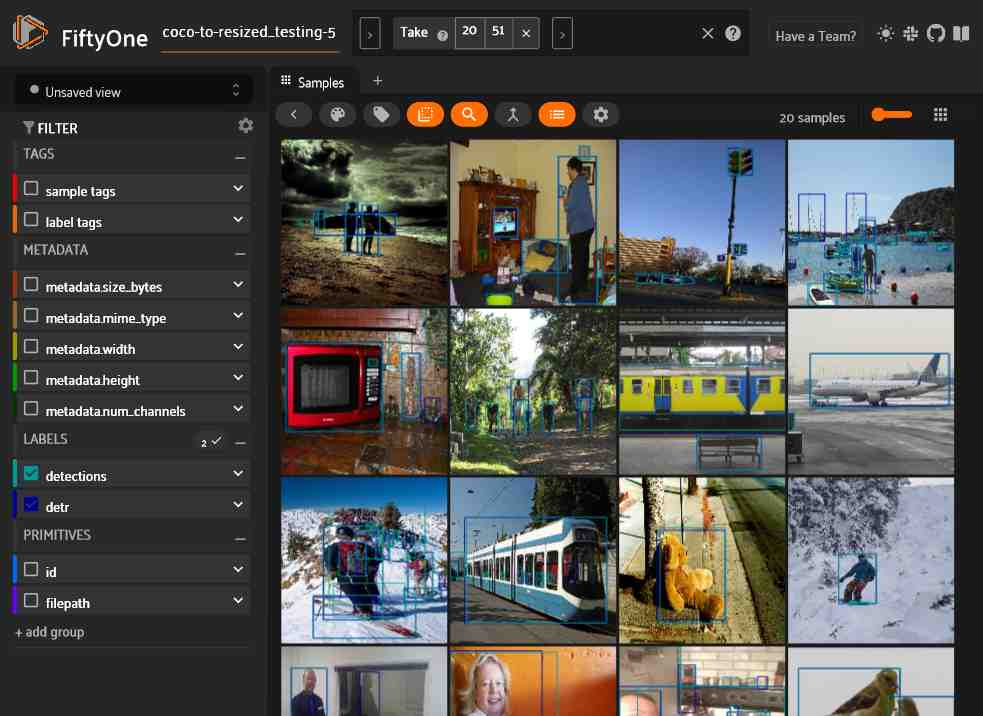

In [10]:
session.view = predictions_view

In [11]:
from fiftyone import ViewField as F

# Only contains detections with confidence >= 0.75
high_conf_view = predictions_view.filter_labels("detr", F("confidence") > 0.75, only_matches=False)

In [12]:
# Print some information about the view
print(high_conf_view)

Dataset:     coco-to-resized_testing-5
Media type:  image
Num samples: 20
Sample fields:
    id:         fiftyone.core.fields.ObjectIdField
    filepath:   fiftyone.core.fields.StringField
    tags:       fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    detections: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    detr:       fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
View stages:
    1. Take(size=20, seed=51)
    2. FilterLabels(field='detr', filter={'$gt': ['$$this.confidence', 0.75]}, only_matches=False, trajectories=False)


In [13]:
# Print a prediction from the view to verify that its confidence is > 0.75
sample = high_conf_view.first()
print(sample.detr.detections[0])

<Detection: {
    'id': '65686e4980d898755590e443',
    'attributes': {},
    'tags': [],
    'label': 'surfboard',
    'bounding_box': [0.442975, 0.4413625, 0.24071250000000005, 0.13],
    'mask': None,
    'confidence': 0.9014533758163452,
    'index': None,
}>



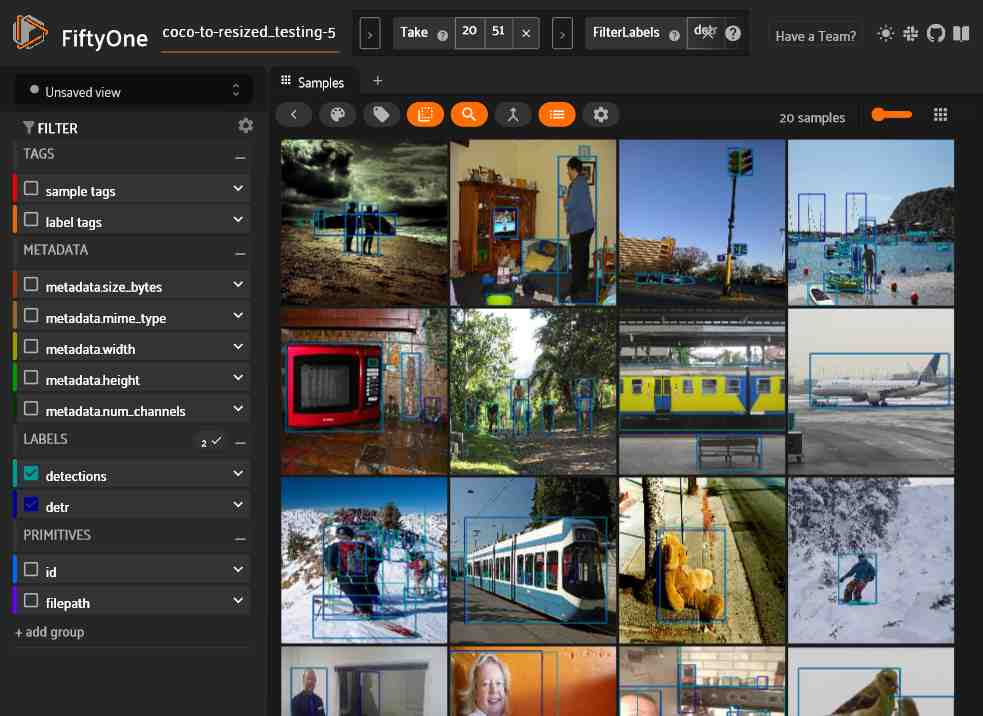

In [14]:
# Load high confidence view in the App
session.view = high_conf_view


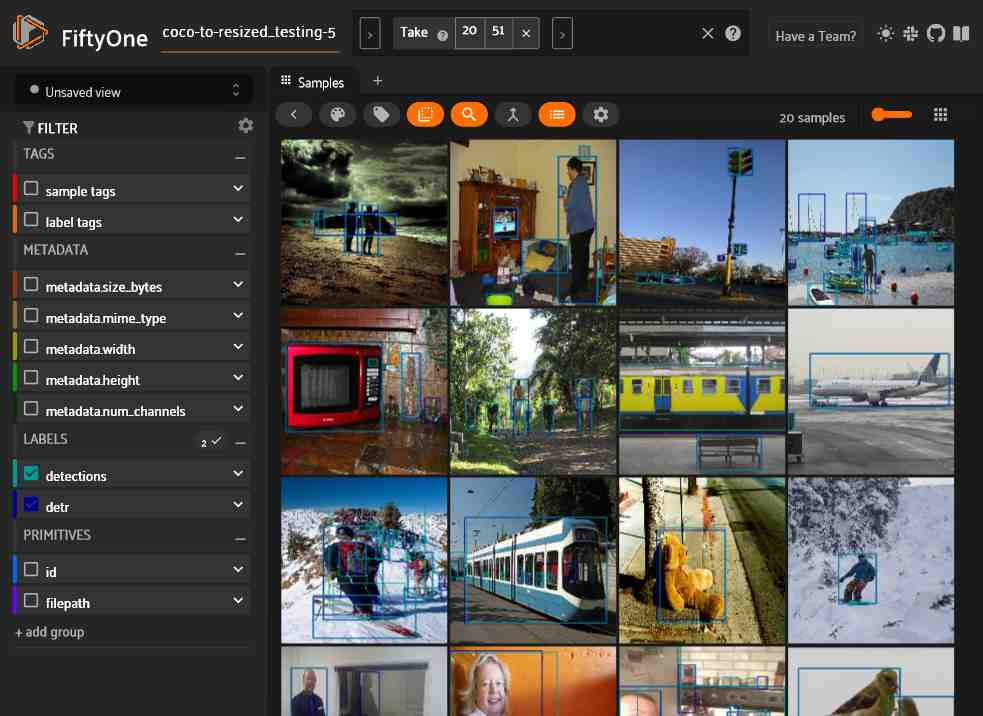

In [15]:
session.view = predictions_view

In [16]:
session.view = predictions_view

In [20]:
# Evaluate the predictions in the `detr` field of our `high_conf_view`
# with respect to the objects in the `ground_truth` field
results = high_conf_view.evaluate_detections(
    "detr",
    gt_field="detections",
    eval_key="detr_eval",
    compute_mAP=True,
)
print(results)

Evaluating detections...
 100% |███████████████████| 20/20 [371.8ms elapsed, 0s remaining, 53.8 samples/s]      
Performing IoU sweep...
 100% |███████████████████| 20/20 [227.6ms elapsed, 0s remaining, 87.9 samples/s]      
{
    "cls": "fiftyone.utils.eval.coco.COCODetectionResults",
    "ytrue": [
        "person",
        "person",
        "person",
        "person",
        "person",
        "person",
        "person",
        "person",
        "surfboard",
        "(none)",
        "tv",
        "couch",
        "couch",
        "person",
        "bowl",
        "(none)",
        "remote",
        "(none)",
        "remote",
        "chair",
        "clock",
        "car",
        "car",
        "car",
        "car",
        "(none)",
        "traffic light",
        "traffic light",
        "(none)",
        "traffic light",
        "traffic light",
        "boat",
        "boat",
        "boat",
        "(none)",
        "boat",
        "boat",
        "(none)",
        "(none)

In [21]:
# Get the 10 most common classes in the dataset
counts = dataset.count_values("detections.detections.label")
classes_top10 = sorted(counts, key=counts.get, reverse=True)[:10]

# Print a classification report for the top-10 classes
results.print_report(classes=classes_top10)

               precision    recall  f1-score   support

       person       0.87      0.49      0.63        53
          car       1.00      0.21      0.35        14
        chair       1.00      1.00      1.00         1
         book       0.00      0.00      0.00         0
       bottle       0.40      0.22      0.29         9
          cup       0.50      1.00      0.67         1
 dining table       1.00      1.00      1.00         1
traffic light       0.50      0.50      0.50         4
         bowl       0.75      0.75      0.75         4
      handbag       0.00      0.00      0.00         0

    micro avg       0.78      0.45      0.57        87
    macro avg       0.60      0.52      0.52        87
 weighted avg       0.82      0.45      0.56        87



In [22]:
print(results.mAP())

0.46342614943198596
